In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/valid.csv
/kaggle/input/train.csv
/kaggle/input/test.csv


In [2]:
# !pip install numpy
# !pip install pandas
# !pip install torch
# !pip install transformers
# !pip install pandas
# !pip install scikit-learn


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
# Load pre-trained model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "bert-base-uncased"  # You can replace with other models like "roberta-base", "distilbert-base-uncased", etc.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model0 = AutoModel.from_pretrained(MODEL_NAME)
# tokenizer.to(device)
model0.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
test_path = "/kaggle/input/test.csv"
data_path = "/kaggle/input/train.csv"
valid_path ="/kaggle/input/valid.csv"

import pandas as pd
data = pd.read_csv(data_path)
df = pd.DataFrame(data).fillna("NONE")
#print(df.columns)
data = pd.read_csv(test_path)
tf = pd.DataFrame(data).fillna("NONE")
data = pd.read_csv(valid_path)
vf = pd.DataFrame(data).fillna("NONE")

In [5]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False 
df=df.fillna('None')
df = df[df["overall_rating"].apply(is_numeric)]
tf=tf[tf["overall_rating"].apply(is_numeric)]
vf=vf[vf["overall_rating"].apply(is_numeric)]


tf['overall_rating'].unique()

array([3. , 4.5, 3.5, 4. , 2.5, 2. , 1.5, 5. , 0. , 1. ])

In [6]:
df['overall_rating'] = ((df["overall_rating"] * 2)).astype(int)
tf['overall_rating'] = ((tf["overall_rating"] * 2)).astype(int)
vf['overall_rating'] = ((vf["overall_rating"] * 2)).astype(int)

In [7]:
def preprocess_data(df):
    tokenized_data = {
        "token_review": tokenizer(
            df['review_text'].tolist(),
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ),
        "token_positive": tokenizer(
            df['positive_comment'].tolist(),
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ),
        "token_negative": tokenizer(
            df['negative_comment'].tolist(),
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ),
        "token_neutral": tokenizer(
            df['neural_comment'].tolist(),
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ),
        
        "labels": torch.tensor(df['overall_rating'].tolist(), dtype=torch.long),

        # Include the original sentences
        "positive_sentences": df['positive_comment'].tolist(),
        "negative_sentences": df['negative_comment'].tolist(),
        "neutral_sentences": df['neural_comment'].tolist(),
    }
    return tokenized_data


In [8]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data["token_review"]["input_ids"].shape[0]

    def __getitem__(self, idx):
        return {
            "text_token": {
                "input_ids": self.data["token_review"]["input_ids"][idx],
                "attention_mask": self.data["token_review"]["attention_mask"][idx],
                "token_type_ids": self.data["token_review"]["token_type_ids"][idx],
            },
            "pos_token": {
                "input_ids": self.data["token_positive"]["input_ids"][idx],
                "attention_mask": self.data["token_positive"]["attention_mask"][idx],
                "token_type_ids": self.data["token_positive"]["token_type_ids"][idx],
            },
            "neg_token": {
                "input_ids": self.data["token_negative"]["input_ids"][idx],
                "attention_mask": self.data["token_negative"]["attention_mask"][idx],
                "token_type_ids": self.data["token_negative"]["token_type_ids"][idx],
            },
            "neu_token": {
                "input_ids": self.data["token_neutral"]["input_ids"][idx],
                "attention_mask": self.data["token_neutral"]["attention_mask"][idx],
                "token_type_ids": self.data["token_neutral"]["token_type_ids"][idx],
            },
            "labels": self.data["labels"][idx],
            "positive_sentence": self.data["positive_sentences"][idx],  # Include positive sentence
            "negative_sentence": self.data["negative_sentences"][idx],  # Include negative sentence
            "neutral_sentence": self.data["neutral_sentences"][idx],    # Include neutral sentence
        }



In [9]:
from sklearn.model_selection import train_test_split
# Preprocess data
train_data = preprocess_data(df)
test_data = preprocess_data(tf)
valid_data = preprocess_data(vf)

In [10]:
#print(train_data['token_review'])

In [11]:
# df['token_review'].
# Create Dataset objects
train_dataset = Custom_Dataset(train_data)
test_dataset = Custom_Dataset(test_data)
valid_dataset = Custom_Dataset(valid_data)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False,drop_last=True)

In [12]:
import torch
import torch.nn as nn

class TransformerConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, cond_dim, hidden_dim, num_layers, num_heads, output_dim, max_seq_len):
        super(TransformerConditionalDecoder, self).__init__()

        # Embedding for latent and condition
        self.latent_cond_embedding = nn.Linear(latent_dim, hidden_dim)

        # Embedding for target sequence (this should use nn.Embedding instead of Linear)
        self.target_embedding = nn.Embedding(output_dim, hidden_dim)

        # Positional encoding for sequence positions
        self.positional_encoding = nn.Embedding(max_seq_len, hidden_dim)

        # Transformer Decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )

        # Output projection to vocabulary size
        self.output_projection = nn.Linear(hidden_dim,output_dim )

    def forward(self, zxc, tgt_seq, tgt_mask=None):
        """
        Args:
        - zxc: Latent variable (batch_size, latent_dim)
        - tgt_seq: Target sequence (batch_size, seq_len)
        - tgt_mask: Causal mask for autoregressive decoding (seq_len, seq_len)

        Returns:
        - logits: Decoded output (batch_size, seq_len, output_dim)
        """
        batch_size, seq_len = tgt_seq.size()

        # Latent condition embedding
        memory = self.latent_cond_embedding(zxc)  # (batch_size, hidden_dim)

        # Embed target sequence and add positional encoding
        tgt_embedded = self.target_embedding(tgt_seq) + self.positional_encoding(
            torch.arange(seq_len, device=tgt_seq.device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
        )

        # Transformer Decoder
        transformer_output = self.transformer_decoder(
            tgt=tgt_embedded, memory=memory, tgt_mask=tgt_mask
        )

        # Project to vocabulary size
        logits = self.output_projection(transformer_output)  # (batch_size, seq_len, output_dim)
        return logits,transformer_output


In [13]:
def Encoder(texts):
    """
    Encodes sentences into contextual word embeddings using BERT.
    
    Args:
        texts (str or List[str]): Single sentence or a batch of sentences.

    Returns:
        torch.Tensor: Contextual word embeddings of shape [batch_size, seq_length, hidden_dim].
    """
    # Tokenize input text(s)
    inputs = texts
    
    # Get embeddings
    with torch.no_grad():
        outputs = model0(**inputs)

    return outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_dim]

In [14]:
def check_tensor_dtype(tensor):
    if tensor.dtype in (torch.int8, torch.int16, torch.int32, torch.int64):
        return "Integer tensor"
    elif tensor.dtype in (torch.float16, torch.float32, torch.float64):
        return "Float tensor"
    else:
        return "Unknown or unsupported dtype"

In [15]:
import torch

def truncate_and_pad(tensor, max_length):
    """Truncates or pads a tensor to a maximum length.

    Args:
        tensor: The input tensor.
        max_length: The maximum desired length.

    Returns:
        The truncated or padded tensor.
    """

    batch_size, seq_len, dim = tensor.size()

    if seq_len > max_length:
        # Truncate
        tensor = tensor[:, :max_length, :]
    elif seq_len < max_length:
        # Pad
        pad_width = (0, 0, 0, max_length - seq_len)
        tensor = F.pad(tensor, pad_width, mode='constant', value=0)

    return tensor


In [16]:
def cross_ent_seq(reconstructed_e,e):
    
    loss=[]
    for i in range(e.shape[0]):
        loss.append(F.cross_entropy(reconstructed_e[i,:,:],e[i,:],reduction="mean"))
    # print(loss)
    loss=torch.tensor(loss).to(device)
    return loss*10


def cvae_loss(reconstructed_e, e, recognition_mu, recognition_logvar, prior_mu, prior_logvar):
    """
    Compute batched CVAE loss.
    """
    
    # Compute reconstruction loss (mean squared error)
    batch_size=e.shape[0]
    seq_len=e.shape[1]
    # # #print("cvae loss")
    # # #print(type(reconstructed_e),type(e),"reconstructed and type",e.shape,reconstructed_e.shape)
    # reconstructed_e = reconstructed_e.view(-1, reconstructed_e.size(-1))

    # # Reshape 'e' to be of shape [batch_size * seq_len]
    # e = e.view(-1)

    # # Compute the cross-entropy loss
    # reconstruction_loss = F.cross_entropy(reconstructed_e, e, reduction='none')

    # Optionally, if you want to compute the mean loss over the sequence length:
    reconstruction_loss = cross_ent_seq(reconstructed_e,e)

    kl_divergence = -0.5 * torch.sum(
        1 + recognition_logvar - prior_logvar - 
        ((recognition_mu - prior_mu) ** 2 + torch.exp(recognition_logvar)) / torch.exp(prior_logvar),
        dim=-1  # Sum over the latent dimensions (e.g., 768)
    )
    # print(torch.sum(reconstruction_loss),torch.sum(kl_divergence),"reconstructoion loss and kl_div")
    # print(reconstruction_loss.shape,kl_divergence.shape)
    
    # Total loss is the sum of reconstruction loss and KL divergence
    total_loss = reconstruction_loss + kl_divergence

    return total_loss# Shape: (batch_size,)




In [17]:
"CVAE"
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, input_dim=768, cond_dim=768, latent_dim=768, hidden_dim=768):
        """
        Conditional Variational Autoencoder (CVAE) implementation.
        
        Args:
        - input_dim: Dimensionality of input text embeddings (x).
        - cond_dim: Dimensionality of the conditional information (c).
        - latent_dim: Dimensionality of the latent variable (z).
        - hidden_dim: Dimensionality of hidden layers in encoders/decoders.
        """
        super(CVAE, self).__init__()

        self.input_encoder=self.explanation_encoder=Encoder

        
        # Recognition Network (Posterior)
        self.recognition_mu =nn.Sequential(
        nn.Linear(1024, 256),
        nn.BatchNorm1d(768),  # Normalize the output of the first Linear layer
        nn.ReLU(),
        nn.Linear(256, 1),
        # nn.LayerNorm(1)     # Optional: Normalize the final output
    )
        self.recognition_logvar =nn.Sequential(
        nn.Linear(1024, 256),
        nn.BatchNorm1d(768),  # Normalize the output of the first Linear layer
        nn.ReLU(),
        nn.Linear(256, 1),
        # nn.LayerNorm(1)    
    )
     
        self.prior_mu =nn.Sequential(
        nn.Linear(512, 128),
        nn.BatchNorm1d(768),  
        nn.ReLU(),
        nn.Linear(128, 1),
        # nn.LayerNorm(1)     
    )
        self.prior_logvar = nn.Sequential(
        nn.Linear(512, 128),
        # nn.LayerNorm(128), 
        nn.BatchNorm1d(768),
        nn.ReLU(),
        nn.Linear(128, 1),
        # nn.LayerNorm(1)     
    )
        
        # Decoder
        self.decoder = TransformerConditionalDecoder(
            latent_dim=768,  
            cond_dim=768,    
            hidden_dim=768, 
            num_layers=4,    
            num_heads=8,     
            output_dim=30522,  
            max_seq_len=512,  
            # dropout=0.1      
        )

    def encode_sent(self,inp,c):

        sent_encodings=self.input_encoder(inp)
        contoll_signal=self.input_encoder(c)[:, 0, :]
        contoll_signal=contoll_signal.unsqueeze(1)
        combined_embeddings = torch.cat([contoll_signal, sent_encodings], dim=1)
        return sent_encodings,combined_embeddings
    
        

    def prior(self, c):
        """
        Compute the prior distribution for the latent variable (z) based on condition (c).
        """
        # res=[]
        # for i in range(3):
        # #print(c.shape)
        c=truncate_and_pad(c,512)
        c=c.transpose(1, 2)
        prior_mu = self.prior_mu(c).squeeze(-1)
        prior_logvar = self.prior_logvar(c).squeeze(-1)
        c_z=self.reparameterize(prior_mu,prior_logvar)
        # #print(prior_mu.shape,"shape of mu",prior_logvar.shape,"shape of logvar")
        return c_z,prior_mu,prior_logvar
    
    def posterior(self,xc):
        "generating recognation latetnt variable z"
        # #print(xc.shape)
        xc=truncate_and_pad(xc,1024)
        xc=xc.transpose(1,2)
        xc_mu=self.recognition_mu(xc).squeeze(-1)
        
        xc_lgvar=self.recognition_logvar(xc).squeeze(-1)
        xc_z=self.reparameterize(xc_mu,xc_lgvar)
        # #print(xc_mu.shape,"shape of mu",xc_lgvar.shape,"shape of logvar")
        # #print(xc_z.shape,"shape of xcz")
        return xc_z,xc_mu,xc_lgvar
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: Sample z ~ N(mu, sigma^2).
        """
 
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode_explanations(self,x,c):
        x_enc=self.explanation_encoder(x)
        # neg_enc=self.explanation_encoder(neg)
        # neu_enc=self.explanation_encoder(neu)
        xc = torch.cat([c, x_enc], dim=1)
        
        return self.posterior(xc),self.prior(c),x_enc
        
    def decode(self, z,inp_c,x_seq):
        """
        Decode latent variable (z) with input (x) and condition (c) to generate explanation.
        """
        zxc=truncate_and_pad(torch.cat([z.unsqueeze(1), inp_c], dim=1),512)
        # #print(zxc.shape)
        return self.decoder(zxc,x_seq)

    def forward(self, inp,x, c):
        """
        Full forward pass of the CVAE.
        """
        inp, inp_c = self.encode_sent(inp,c)
        (z,xc_mu,xc_logvar),(z1,c_mu,c_logvar),x_enc=self.encode_explanations(x,inp_c)

        
        
        logits,reconstructed_e = self.decode(z,inp_c,x['input_ids'])
        # #print(reconstructed_e)
        return logits,reconstructed_e,inp,x_enc,z,z1,xc_mu,xc_logvar,c_mu,c_logvar

In [18]:
"The GEF model"
input_dim = 768
num_classes=11

def repeat_neutral_comment(comment, tokenizer, batch_size):
    return {k: v.repeat(batch_size, 1).to(device) for k, v in tokenizer(comment, padding="max_length", truncation=True, max_length=512, return_tensors="pt").items()}


class GEF_Model(nn.Module):
    def __init__(self):

        # CVAE block
        super(GEF_Model, self).__init__()
        self.cvae=CVAE()

        self.Predictor= nn.Sequential(
            # nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 256),  
            nn.ReLU(),                
            nn.Dropout(0.1),           
            nn.Linear(256, num_classes)  
        )

        self.Classifier_gru = nn.GRU(
            input_dim, 384, num_layers=1, 
            bidirectional=True, batch_first=True, dropout=0.1
        )
        
        self.classifer_fc = nn.Sequential(
            nn.Linear(768, 256), 
            nn.ReLU(),
            # nn.LayerNorm(256),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes),
            nn.Flatten(),
            nn.BatchNorm1d(33),
            nn.ReLU(),
            nn.Linear(3*num_classes,num_classes)
        )


    def forward(self, sentences,positives,negatives,neutrals,inference=False):
        # #print(positives)
        # #print(positives['input_ids'].shape,"pos")
        logit_pos,positive_embb,sent_emm,pos_enc,z_pos,z1_pos,xc_mu_pos,xc_logvar_pos,c_mu_pos,c_logvar_pos = self.cvae(sentences,positives,repeat_neutral_comment("Positive comment", tokenizer, len(positives["input_ids"])))
        logit_neg,negative_embb,_,neg_enc,z_neg,z1_neg,xc_mu_neg,xc_logvar_neg,c_mu_neg,c_logvar_neg = self.cvae(sentences,negatives,  repeat_neutral_comment("negative comment", tokenizer, len(positives["input_ids"])))
        logit_neu,neutral_embb,_,neu_enc,z_neu,z1_neu,xc_mu_neu,xc_logvar_neu,c_mu_neu,c_logvar_neu= self.cvae(sentences,neutrals, repeat_neutral_comment("neutral comment", tokenizer, len(positives["input_ids"])))
        loss_gen=cvae_loss(logit_pos,positives['input_ids'],xc_mu_pos,xc_logvar_pos,c_mu_pos,c_logvar_pos)+cvae_loss(logit_neg,negatives['input_ids'],xc_mu_neg,xc_logvar_neg,c_mu_neg,c_logvar_neg)+cvae_loss(logit_neu,neutrals['input_ids'],xc_mu_neu,xc_logvar_neu,c_mu_neu,c_logvar_neu)
        pred_out=self.Predictor(sent_emm[:, 0, :])
        # #print(sent_emm[:, 0, :].shape)
        class_con=[]
        "p classifed"
        if inference:
            z_pos=z1_pos
            z_neg=z1_neg
            z_neu=z1_neu
        pos_gen=self.Classifier_gru(positive_embb)[0]
        neg_gen=self.Classifier_gru(negative_embb)[0]
        neu_gen=self.Classifier_gru(neutral_embb)[0]
        # #print(len(pos_gen),type(pos_gen))
        class_con.append(torch.squeeze(pos_gen[:,-1,:],1))
        class_con.append(torch.squeeze(neg_gen[:,-1,:],1))
        class_con.append(torch.squeeze(neu_gen[:,-1,:],1))
        stacked_outputs = torch.stack(class_con, dim=1)
        cla_out=self.classifer_fc(stacked_outputs)
        "p_gold"
        class_gold=[]
        pos_gold=self.Classifier_gru(pos_enc)[0]
        neg_gold=self.Classifier_gru(neg_enc)[0]
        neu_gold=self.Classifier_gru(neu_enc)[0]
        # #print(len(pos_gen),type(pos_gen))
        class_gold.append(torch.squeeze(pos_gold[:,-1,:],1))
        class_gold.append(torch.squeeze(neg_gold[:,-1,:],1))
        class_gold.append(torch.squeeze(neu_gold[:,-1,:],1))
        stacked_outputs_gold = torch.stack(class_gold, dim=1)
        cla_out_gold=self.classifer_fc(stacked_outputs_gold)
        return cla_out,pred_out,logit_pos,logit_neg,logit_neu,loss_gen,cla_out_gold
        




In [19]:
#print(device)
def check_gradients_for_nan(model):
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"Gradient has NaN values in parameter: {name}")
            return True
    print("No NaN gradients found.")
    return False

# Example usage


In [20]:
"Training phase"
model_gef=GEF_Model()
model_gef.to(device)

criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(params=model_gef.parameters(), lr=0.004)
model_gef.train()
best_acc=0
best_model_state_dict = None
w=0.05
# Initialize lists to store loss values
loss_gen_values = []
loss_predictor_values = []
loss_total_values = []

try:
    for j in range(5):
        correct=0
        w=w*5
        total=0
        for i, batch in enumerate(train_loader):
            # if i==2:
            
            #     break
            if i % 200 == 0:
                print(i)
                check_gradients_for_nan(model_gef)


            sent,pos,neg,neu,ground = batch['text_token'],batch['pos_token'],batch['neg_token'],batch['neu_token'],batch['labels']
            sent = {key: value.to(device) for key, value in batch['text_token'].items()}
            pos = {key: value.to(device) for key, value in batch['pos_token'].items()}
            neg = {key: value.to(device) for key, value in batch['neg_token'].items()}
            neu = {key: value.to(device) for key, value in batch['neu_token'].items()}
            ground = ground.to(device)
            


            cla_out,pred_out,positive_embb,negative_embb,neutral_embb,loss_gen,cla_out_gold=model_gef(sent,pos,neg,neu)
            loss_predictor=criterion(pred_out, ground)
            # print(loss_predictor)
            cla_pob= F.softmax(cla_out, dim=-1)
            cla_gold=F.softmax(cla_out_gold,dim=-1)
            pred_pob=F.softmax(pred_out,dim=-1)
            max_index = torch.argmax(pred_pob)

            predicted_classes = torch.argmax(pred_pob, dim=1)
            correct+=(predicted_classes == ground).sum().item()
            total += ground.size(0)
            # Compute EF efficiently
            EF = torch.abs(cla_pob[torch.arange(sent['input_ids'].shape[0]), ground] - cla_gold[torch.arange(sent['input_ids'].shape[0]), ground]) + \
                torch.abs(cla_pob[torch.arange(sent['input_ids'].shape[0]), ground] - pred_pob[torch.arange(sent['input_ids'].shape[0]), ground])

            EF = EF.unsqueeze(1)  # Shape: (batch_size, 1)

            # Compute loss_gen_predictor
            loss_gen_predictor = w*0.05*loss_gen + 2*loss_predictor  # Shape: (batch_size,)
            # print(EF.shape,loss_gen_predictor.shape)
            # Compute dot product
            if i % 200 == 0:
                print( "loss gen",torch.sum(w*0.5*loss_gen),"loss pred",torch.sum(2*loss_predictor),)
            dot_product = (EF.squeeze(1) * loss_gen_predictor).sum(dim=-1)  # Shape: (batch_size,)
            # print(dot_product)

            # Compute total loss
            loss_total = torch.mean(loss_gen_predictor + dot_product)  # Shape: (batch_size,)
            # loss_total=torch.sum(loss_gen)
            # if j<1:
            #    loss_total=loss_total+ criterion(cla_out,ground).sum(dim=-1)

            optimizer.zero_grad()
            loss_total.backward()
            # torch.nn.utils.clip_grad_norm_(model_gef.parameters(), max_norm=1.0)
            optimizer.step()
            # After calculating losses in each training iteration or epoch
            loss_gen_values.append(torch.mean(w * 0.5 * loss_gen).item())
            loss_predictor_values.append(torch.mean(2 * loss_predictor).item())
            # loss_total = torch.mean(loss_gen_predictor + dot_product)
            loss_total_values.append(loss_total.item())

        acc=correct/total
        print(f"accuracy is {acc}")
        if(acc>best_acc):
            best_accuracy = acc
            best_model_state_dict = model_gef.state_dict()

            
        

except KeyboardInterrupt:
    print("Training interrupted by the user.")
torch.save(best_model_state_dict, 'best_model.pth')

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0
No NaN gradients found.
loss gen tensor(404.2813, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(19.4152, device='cuda:0', grad_fn=<SumBackward0>)
200
No NaN gradients found.
loss gen tensor(160.1628, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(17.3265, device='cuda:0', grad_fn=<SumBackward0>)
400
No NaN gradients found.
loss gen tensor(156.6835, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(17.3915, device='cuda:0', grad_fn=<SumBackward0>)
600
No NaN gradients found.
loss gen tensor(157.1797, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(15.0238, device='cuda:0', grad_fn=<SumBackward0>)
800
No NaN gradients found.
loss gen tensor(155.7112, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(14.4506, device='cuda:0', grad_fn=<SumBackward0>)
1000
No NaN gradients found.
loss gen tensor(163.0589, device='cuda:0', grad_fn=<SumBackward0>) loss pred tensor(13.5917, device='cuda:0', grad_fn=<SumBackward0>)
1200
No NaN gradients found.


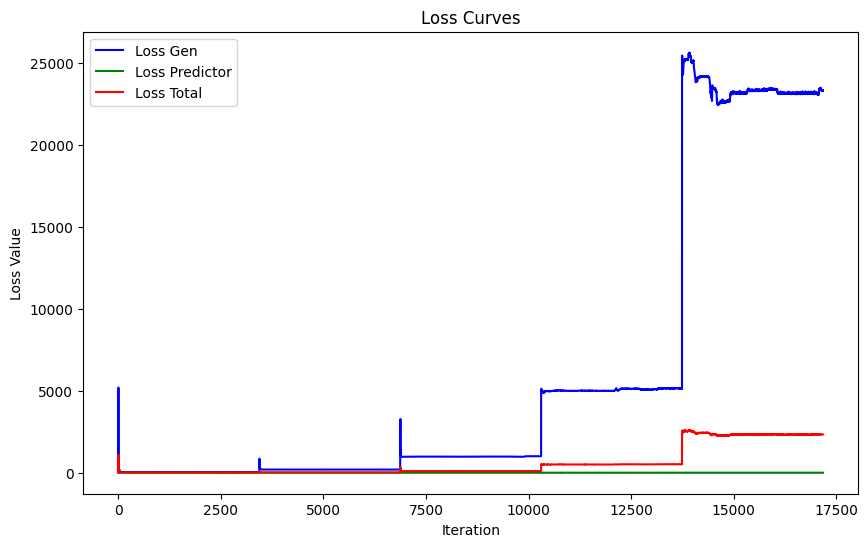

In [21]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 6))

# Plot each loss
plt.plot(loss_gen_values, label="Loss Gen", color="blue")
plt.plot(loss_predictor_values, label="Loss Predictor", color="green")
plt.plot(loss_total_values, label="Loss Total", color="red")

# Add labels, title, and legend
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Loss Curves")
plt.legend()

# Show the plot
plt.show()


In [22]:
# for name, param in model_gef.named_parameters():
#     if param.requires_grad:
#         print(f"{name} gradient: {param.grad}")
!pip install rouge-score


from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from rouge_score import rouge_scorer

def compute_rouge(reference, hypothesis) -> dict:
    """
    Compute the ROUGE-L score between two lists of strings.
    
    Args:
        reference (list of str): The reference strings (ground truth).
        hypothesis (list of str): The hypothesis strings (model predictions).
    
    Returns:
        dict: The average ROUGE-L scores (precision, recall, and F1) across all pairs.
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_precision = 0
    rouge_recall = 0
    rouge_f1 = 0
    
    for ref, hyp in zip(reference, hypothesis):
        scores = scorer.score(ref, hyp)['rougeL']
        rouge_precision += scores.precision
        rouge_recall += scores.recall
        rouge_f1 += scores.fmeasure
    
    n = len(reference)
    return {
        "precision": rouge_precision / n,
        "recall": rouge_recall / n,
        "f1": rouge_f1 / n
    }



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=140dc5c7c344c1c4ec50b888d5face839d3f31042ee9efb59fff96eda2668a31
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [23]:
blue_pos=0
blue_neg=0
ble_neu=0
def model_logits_to_text(logits,l):
    # Step 1: Get predicted token IDs
    predicted_token_ids = torch.argmax(logits, dim=-1)  # Shape: [batch_size, seq_len]
    
    # Step 2: Convert token IDs to tokens
    token_strings = []
    for token_ids in predicted_token_ids:
        # Decode tokens for each sequence in the batch
        tokens = tokenizer.convert_ids_to_tokens(token_ids.tolist())
        token_strings.append(tokens)
    
    # Step 3: Convert tokens to readable strings
     
    for tokens in token_strings:
        text = tokenizer.convert_tokens_to_string(tokens)
        l.append(text)
    
    # Output results




# Inference Phase
model_gef.eval()  # Set model to evaluation mode
correct = 0
total = 0
pos_gen_l=[]
neg_gen_l=[]
neu_gen_l=[]
pos_l=[]
neg_l=[]
neu_l=[]
def add_to_list(items,l):
    # print(items)
    for item in items:
        l.append(item)
with torch.no_grad():  # Disable gradient computation
    for i, batch in enumerate(test_loader):  # Use your test/validation loader
        if i % 200 == 5:
            print(i)

        sent, pos, neg, neu, ground = batch['text_token'], batch['pos_token'], batch['neg_token'], batch['neu_token'], batch['labels']
        pos_cmnt = batch["positive_sentence"]
        neg_cmnt = batch["negative_sentence"]
        neu_cmnt = batch["neutral_sentence"]
        
        sent = {key: value.to(device) for key, value in batch['text_token'].items()}
        pos = {key: value.to(device) for key, value in batch['pos_token'].items()}
        neg = {key: value.to(device) for key, value in batch['neg_token'].items()}
        neu = {key: value.to(device) for key, value in batch['neu_token'].items()}
        ground = ground.to(device)

        # Forward pass
        cla_out, pred_out, positive_embb, negative_embb, neutral_embb, loss_gen, cla_out_gold = model_gef(sent, pos, neg, neu,True)
        # print(pos_cmnt,positive_embb)
        cla_pob = F.softmax(cla_out, dim=-1)
        pred_pob = F.softmax(pred_out, dim=-1)
        predicted_classes = torch.argmax(pred_pob, dim=1)

        correct += (predicted_classes == ground).sum().item()
        total += ground.size(0)
        model_logits_to_text(positive_embb,pos_gen_l)
        add_to_list(pos_cmnt,pos_l)
        model_logits_to_text(negative_embb,neg_gen_l)
        add_to_list(neg_cmnt,neg_l)
        model_logits_to_text(neutral_embb,neu_gen_l)
        add_to_list(neu_cmnt,neu_l)
    # Compute final accuracy
    acc = correct / total
    print(f"Accuracy during inference is {acc}")
print(pos_gen_l,pos_l)

print(f"positive blue score : {compute_rouge(pos_gen_l,pos_l)}")
print(f"negative blue score : {compute_rouge(neg_gen_l,neg_l)}")
print(f"negative blue score : {compute_rouge(neu_gen_l,neu_l)}")


5
205
Accuracy during inference is 0.34170560747663553
['51st hanson lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lottery lot